[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/110_hf_intro/110_hf_intro.ipynb)

# 🤗 Hugging Face

[Huggin Face](https://huggingface.co/) es una empresa con el objetivo de desarrollar herramientas de código abierto para el diseño, entrenamiento y puesta en producción de modelos de Inteligencia Artificial. Creada en 2016, empezó a ganar popularidad gracias a su librería [transformers](https://huggingface.co/docs/transformers/index), la cual permite crear y entrenar redes neuronales con la arquitectura [Transformer](https://arxiv.org/abs/1706.03762) de manera sencilla e independiente del framework agnóstica, pudiendo usar en el backend tanto Pytorch como Tensorflo o JAX. Hoy en día, sin embargo, ofrece muchas otras funcionalidades tales como Datasets, Modelos pre-entrenados, herramientas para el entrenamiento y puesta en producción de modelos a escala, etc. Recientemente incluso han incluído en su catálogo la librería [timm](https://huggingface.co/docs/timm/index), que hemos usado en muchos de los posts de este blog, o [diffusers](https://huggingface.co/docs/diffusers/index), para la generación de imágenes al estilo DALL-E o Stable Diffusion, indicando que Hugging Face está creciendo como comunidad, yendo más allá de los Transfromers y sus aplicaciones en tareas de lenguaje hacia otros campos como el de la visión artificial o el aprendizaje por refuerzo. En este post vamos a ver una introducción al ecosistema de Hugging Face para tareas de procesamiento de lenguaje natural (NLP).

![eco](./eco.png)

## Transformers

La primera pieza del ecosistema Hugging Face que vamos a ver es la librería [transformers](https://huggingface.co/docs/transformers/index). Como su propio nombre indica, nos va a permitir crear y entrenar modelos usando la arquitectura del [Transformer](https://arxiv.org/abs/1706.03762), de la cual ya hemos hablado en posts anteriores y que si no conoces te recomiendo que le eches un vistazo antes de continuar.

> Puedes aprender más sobre Transformers [aquí](https://www.youtube.com/watch?v=ZpO5A9hUP6c&list=PLkgbkukKg_NpdJPhhHbemaWHNQCY-lmh1&index=28).

Esto nos permitirá entrenar modelos como los derivados de las familias GPT, BERT, etc (siempre y cuando tengamos los recursos computacionales necesarios). Y, gracias a la librería, podremos hacerlo con una interfaz unificada, usando nuestro framework favorito (aquí usaremos Pytorch) y sin tener que preocuparnos por aspectos tediosos como el pre-procesado de los datos o su entrenamiento de forma eficaz. Empezaremos instalando la librería con el comando

```
pip install transformers
```

La primera entidad que debemos conocer en esta librería es la `pipeline`, una capa de alto nivel que nos permite resolver una tarea de manera sencilla. 

In [1]:
from transformers import pipeline

classifier = pipeline("text-classification")
classifier("We are very happy to learn about the 🤗 Transformers library.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998134970664978}]

Sencillo, ¿verdad?. Simplemente indicando la tarea que queremos resolver (puedes encontrarlas todas [aquí](https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/pipelines#transformers.pipeline)) y pasando un ejemplo de input, la `pipeline` nos devuelve el output. La primera vez que lo ejecutes verás que se descargan varios archivos, y esto es porque la librería usará un modelo por defecto. Aún así, podemos indicar el modelo que queremos usar fácilmente, seleccionando uno de su enorme [lista](https://huggingface.co/models). Vamos a ver un ejemplo para traducir texto de castellano a inglés.

In [2]:
traductor = pipeline("translation", model="Helsinki-NLP/opus-mt-es-en")
traductor("Hola, ¿cómo estás?")

/home/juan/miniconda3/lib/python3.8/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'Hey, how are you?'}]

De esta manera sencilla puedes resolver otras tareas como la generación de texto, análisis de sentimiento, generar resúmenes, responder preguntas, etc, con cualquiera de los modelos usados hoy en día como GPT-3, RoBERTa y muchos otros.

![models](./models.png)

Si indagamos en el funcionamiento de una `pipeline` podemos ver que está formada por 3 elementos

![](./pipeline.png)

La librería transformers nos da acceso a ellos por si queremos crear flujos más complejos. 

In [3]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "I really enjoy these posts.",
    "I hate this so much!",
]

inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 1045, 2428, 5959, 2122, 8466, 1012,  102],
        [ 101, 1045, 5223, 2023, 2061, 2172,  999,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])}

Podemos instanciar cualquier tokenizador usando el `checkpoint` del modelo que queramos. Una vez descargado, podremos pasarle texto para que nos devuelva los tensores que necesitamos como inputs de un modelo. De la misma manera, podemos crear un modelo y obtener sus outputs (los `logits`).

In [4]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

outputs = model(**inputs)
outputs

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutput(last_hidden_state=tensor([[[ 0.5305,  0.1890,  0.3755,  ...,  0.6808,  1.1315, -0.3421],
         [ 0.8623,  0.3477,  0.3510,  ...,  0.5624,  1.2217, -0.3176],
         [ 0.9040,  0.2511,  0.3321,  ...,  0.5247,  1.1064, -0.4115],
         ...,
         [ 0.6443,  0.2357,  0.4324,  ...,  0.4932,  1.0420, -0.1390],
         [ 1.0914,  0.1559,  0.7788,  ...,  0.7382,  0.6909, -0.8387],
         [ 0.9780,  0.1948,  0.6950,  ...,  0.7812,  0.8553, -0.7071]],

        [[-0.2937,  0.7283, -0.1497,  ..., -0.1187, -1.0227, -0.0422],
         [-0.2206,  0.9384, -0.0951,  ..., -0.3643, -0.6605,  0.2407],
         [-0.1536,  0.8988, -0.0728,  ..., -0.2189, -0.8528,  0.0710],
         ...,
         [-0.2443,  0.7035, -0.1199,  ..., -0.3341, -0.9158,  0.1711],
         [-0.0289,  0.9006, -0.2142,  ..., -0.2135, -0.9266, -0.1390],
         [ 0.0472,  0.3603, -0.1729,  ..., -0.3191, -0.9299, -0.1047]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

Por último, necesitamos convertir las salidas del modelo a algo que podamos entender, lo cual dependerá de la tarea en cuestión.

In [5]:
from transformers import AutoModelForSequenceClassification
import torch

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

El `AutoModel` nos permite acceder a las salidas de un modelo, mientras que para post-procesar las salidas para una tarea concreta deberemos escoger el modelo adecuado de [esta lista](https://huggingface.co/docs/transformers/model_doc/auto).

Finalmente, podemos ir más allá e instanciar directamente el modelo que queramos de aquellos [disponibles](https://huggingface.co/models).

In [6]:
from transformers import BertConfig, BertModel

# random init

config = BertConfig()
model = BertModel(config)

# pre-entrando

model = BertModel.from_pretrained("bert-base-cased")

model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

## Datasets

La librería [datasets](https://huggingface.co/docs/datasets/index) nos da acceso al catálogo de datasets no sólo para tareas de NLP sino para otras como computer vision o audio. Además, nos provee de funcionalidades para el procesado de los datos, trabajar con datos locales y métricas para la evaluación de los modelos. Para empezar, vamos a instalar la librería

```
pip install datasets
```

Podemos explorar la lista de datasets [disponibles](https://huggingface.co/datasets).

In [7]:
from datasets import list_datasets, load_dataset

all_datasets = list_datasets()
len(all_datasets), all_datasets[:5]

(12334,
 ['acronym_identification',
  'ade_corpus_v2',
  'adversarial_qa',
  'aeslc',
  'afrikaans_ner_corpus'])

Y descargar el que queramos usar

In [8]:
dataset = load_dataset("rotten_tomatoes")
dataset

Found cached dataset rotten_tomatoes (/home/juan/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [9]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})

In [10]:
dataset['train'][0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

También es posible cargar tus propios datos, por ejemplo podemos cargar El Quijote que usamos hace unos cuantos posts.

![](./data.png)

In [70]:
el_quijote = load_dataset("text", data_files="https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/el_quijote.txt")
el_quijote

Using custom data configuration default-12ddfefd75f12996
Found cached dataset text (/home/juan/.cache/huggingface/datasets/text/default-12ddfefd75f12996/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2186
    })
})

In [12]:
el_quijote['train'][:6]

{'text': ['DON QUIJOTE DE LA MANCHA',
  'Miguel de Cervantes Saavedra',
  '',
  'PRIMERA PARTE',
  'CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha',
  'En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta 

La librería `datasets` ofrece funcionalidad para el procesado de los datos, sin embargo es común utilizar librerías como [Pandas](https://pandas.pydata.org/) para ello debido a su popularidad y herramientas de visualización.

In [13]:
import pandas as pd 

dataset.set_format(type='pandas')
df = dataset['train'][:]
df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [14]:
def label_int2str(row):
	return dataset['train'].features['label'].int2str(row)

df['name'] = df['label'].apply(label_int2str)
df.head()

,text,label,name
0,the rock is destined to be the 21st century's ...,1,pos
1,"the gorgeously elaborate continuation of "" the...",1,pos
2,effective but too-tepid biopic,1,pos
3,if you sometimes like to go to the movies to h...,1,pos
4,"emerges as something rare , an issue movie tha...",1,pos


In [15]:
df['name'].value_counts()

pos    4265
neg    4265
Name: name, dtype: int64

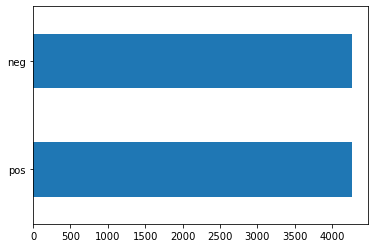

In [16]:
import matplotlib.pyplot as plt

df['name'].value_counts().plot(kind='barh')
plt.show()

Cuando entrenamos modelos necesitamos acceder e iterar nuestros datos de la manera más rápida posible. La librería `datasets` está diseñada para poder trabajar de manera eficiente, aprovechando diversas estrategias como `memory mapping` o `streaming` para una máxima velocidad. Por último, puedes subir tus datasets fácilmente a través de la interfaz de Hugging Face para poder acceder a ellos desde cualquier parte o usando [huggingface_hub](https://huggingface.co/docs/huggingface_hub/index) direcamente desde tu código. 

## Tokenizers

Si bien en la sección anterior hemos visto como descargar o crear datasets, no podemos usar el texto directamente para entrenar un modelo. Para ello, primero deberemos convertir el texto a números en el proceso conocido como tokenización. La liberaría [tokenizers](https://huggingface.co/docs/tokenizers/index) ofrece diferentes estrategias de tokenización implementadas en Rust (por lo que son *blazingly fast*). Puedes instalar la librería con el comando

```
pip install tokenizers
```

aunque esta librería es usada internamente por la librería `transformers`, por lo que ya la deberías tener instalada.

Como ya hemos visto anteriormente, la opción más simple es usar un tokenizador ya existente

In [29]:
from transformers import AutoTokenizer

checkpoint = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

input = "Hola, ¿qué tal?"
inputs = tokenizer(input)
inputs

{'input_ids': [4, 1734, 1019, 1063, 1140, 1713, 1059, 5], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

Pero también podemos crear nuestros propios tokenizadores. Para ello, `tokenizers` nos da acceso a funcionalidades para: normalizar, pre-tokenizar, modelizar y post-procesar nuestro texto para dejarlo listo para entrenar modelos. 



![](./tokenizer.png)


La normalización consiste en la limpieza general del texto, eliminando espacios innecesarios, pasando el texto a minúsculas, quitando acentos, etc.

In [48]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

norm_input = tokenizer.normalizer.normalize_str(input)
norm_input

'hola, ¿que tal?'

La pre-tokenización consiste en separar el texto en palabras

In [46]:
pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Punctuation()]
)
pretoken_input = tokenizer.pre_tokenizer.pre_tokenize_str(norm_input)
pretoken_input

[('hola', (0, 4)),
 (',', (4, 5)),
 ('¿', (6, 7)),
 ('que', (7, 10)),
 ('tal', (11, 14)),
 ('?', (14, 15))]

El modelo (del tokenizador) se encargará de generar las entidades que usaremos para entrenar el modelo (la red neuroanl). Una terminología un poco confusa pero 🤷‍♂️. Existen varias opciones para ello, como `Byte-Pair encoding` o `WordPiece`. Estos modelos deben ser "entrenados" para generar el vocabulario, calcular frecuencia de palabras, etc.

In [50]:
!wget "https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/el_quijote.txt"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2022-10-23 19:18:48--  https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/el_quijote.txt
Resolving mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud (mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud)... 158.177.118.97
Connecting to mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud (mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud)|158.177.118.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060259 (1,0M) [application/octet-stream]
Saving to: ‘el_quijote.txt’

el_quijote.txt      100%[===================>]   1,01M   634KB/s    in 1,6s    

2022-10-23 19:18:50 (634 KB/s) - ‘el_quijote.t

In [51]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)
tokenizer.train(["el_quijote.txt"], trainer=trainer)

In [54]:
encoding = tokenizer.encode(input)
encoding.tokens

['h', '##ol', '##a, ¿', '##que ', '##tal', '##?']

Por último, la etapa de post-procesado añadirá los tokens especiales necesarios para entrenar el modelo (inicio y final de frase, por ejemplo).

In [58]:
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")

tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[("[CLS]", cls_token_id), ("[SEP]", sep_token_id)],
)

encoding = tokenizer.encode(input)
encoding.tokens

['[CLS]', 'h', '##ol', '##a, ¿', '##que ', '##tal', '##?', '[SEP]']

Y ya podemos obtener los valores finales que usaremos durante el entrenamiento.

In [61]:
encoding.ids

[2, 38, 218, 16578, 136, 597, 98, 3]

Para poder re-utilizar tu tokenizador, es aconsejable añadir un decodificador para poder recuperar texto a partir de números (que usaremos para los outputs del modelo).

In [62]:
tokenizer.decoder = decoders.WordPiece(prefix="##")
tokenizer.decode(encoding.ids)

'hola, ¿que tal?'

Y puedes guardarlo en un archivo de texto

In [63]:
tokenizer.save("tokenizer.json")
new_tokenizer = Tokenizer.from_file("tokenizer.json")

De la misma manera que con los datasets, puedes subir tus tokenizers al HuggingFace HUB. Puedes aprender más sobre cómo crear tu propio tokenizador [aquí](https://huggingface.co/course/chapter6/8?fw=pt).

## Accelerate

## Spaces

Ejemplo simple con Gradio

## Resumen

Aprende más sobre Huggingface con el [curso](https://huggingface.co/course/chapter1/1) gratis oficial o el [libro](https://www.amazon.es/Natural-Language-Processing-Transformers-Applications/dp/1098103246/ref=sr_1_1?__mk_es_ES=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=2K5FSCNIFO784&keywords=nlp+with+transformers&qid=1666515915&qu=eyJxc2MiOiIwLjUzIiwicXNhIjoiMC4wMCIsInFzcCI6IjAuMDAifQ%3D%3D&sprefix=nlp+with+transformer%2Caps%2C141&sr=8-1).